In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters * 4, 4, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters * 4),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 4, n_filters * 2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters * 2),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters * 2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh(),
    )
    return model


class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters, n_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 2, n_filters * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(n_filters * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [4]:
z_size = 100
image_size = (28, 28)
n_filters = 32
gen_model = make_generator_network(z_size, n_filters).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [5]:
x = torch.tensor(np.random.randn(1, z_size), dtype=torch.float32).to(device)
print(x.shape)
print(x.unsqueeze(2).shape)
print(x.view(*x.shape, 1, 1).shape)

if len(x.shape) == 2:
    x = x.view(*x.shape, 1, 1)

print(x.shape)
gen_model(x).shape

torch.Size([1, 100])
torch.Size([1, 100, 1])
torch.Size([1, 100, 1, 1])
torch.Size([1, 100, 1, 1])


torch.Size([1, 1, 28, 28])

In [6]:
disc_model = Discriminator(n_filters).to(device)
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [7]:
image_path = "./data/"

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5), std=(0.5)),
    ]
)
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True
)
example, label = next(iter(mnist_dataset))
print(f"Min: {example.min()} Max: {example.max()}")
print(example.shape)

Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [8]:
mnist_dataset[0][0].unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [9]:
x = mnist_dataset[0][0].unsqueeze(0).to(device)
print(x.shape)

disc_model(x).shape

torch.Size([1, 1, 28, 28])


torch.Size([1])

In [10]:
len(mnist_dataset)

60000

In [11]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [12]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [13]:
batch_size = 32
mnist_dl = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(mnist_dl))
input_real = input_real.view(batch_size, -1)
torch.manual_seed(1)
mode_z = "uniform"

In [14]:
create_noise(batch_size, z_size, mode_z).shape

torch.Size([32, 100, 1, 1])

In [11]:
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)
    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

## Train the generator
def g_train(x):
    gen_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones(batch_size, 1, device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)
    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.item()

In [21]:
def create_samples(g_model, input_z, batch_size=1):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))
    return (images + 1) / 2.0


In [12]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 100

fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
epoch_samples = []
torch.manual_seed(1)
for epoch in range(1, num_epochs + 1):
    gen_model.train()
    d_losses, g_losses = [], []
    d_vals_real, d_vals_fake = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
        d_vals_real.append(d_proba_real.mean().cpu())
        d_vals_fake.append(d_proba_fake.mean().cpu())

    all_d_losses.append(torch.tensor(d_losses).mean())
    all_g_losses.append(torch.tensor(g_losses).mean())
    all_d_real.append(torch.tensor(d_vals_real).mean())
    all_d_fake.append(torch.tensor(d_vals_fake).mean())

    print(
        f"Epoch {epoch:03d} | Avg Losses >>"
        f" G/D {torch.FloatTensor(g_losses).mean():.4f}"
        f"/{torch.FloatTensor(d_losses).mean():.4f}"
    )
    gen_model.eval()
    epoch_samples.append(create_samples(gen_model, fixed_z, batch_size=batch_size).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.6734/0.1593
Epoch 002 | Avg Losses >> G/D 2.9256/0.4838
Epoch 003 | Avg Losses >> G/D 2.1957/0.6070
Epoch 004 | Avg Losses >> G/D 2.1444/0.6118
Epoch 005 | Avg Losses >> G/D 2.3126/0.5457
Epoch 006 | Avg Losses >> G/D 2.3430/0.5326
Epoch 007 | Avg Losses >> G/D 2.3751/0.5213
Epoch 008 | Avg Losses >> G/D 2.4619/0.4839
Epoch 009 | Avg Losses >> G/D 2.5241/0.4870
Epoch 010 | Avg Losses >> G/D 2.6473/0.4424
Epoch 011 | Avg Losses >> G/D 2.7354/0.3929
Epoch 012 | Avg Losses >> G/D 2.8775/0.3935
Epoch 013 | Avg Losses >> G/D 2.9317/0.3776
Epoch 014 | Avg Losses >> G/D 3.0160/0.3435
Epoch 015 | Avg Losses >> G/D 3.0515/0.3628
Epoch 016 | Avg Losses >> G/D 3.0694/0.3429
Epoch 017 | Avg Losses >> G/D 3.1599/0.3194
Epoch 018 | Avg Losses >> G/D 3.2540/0.3133
Epoch 019 | Avg Losses >> G/D 3.3001/0.3038
Epoch 020 | Avg Losses >> G/D 3.3644/0.2922
Epoch 021 | Avg Losses >> G/D 3.4849/0.2867
Epoch 022 | Avg Losses >> G/D 3.5193/0.2558
Epoch 023 | Avg Losses >> G/D 3.

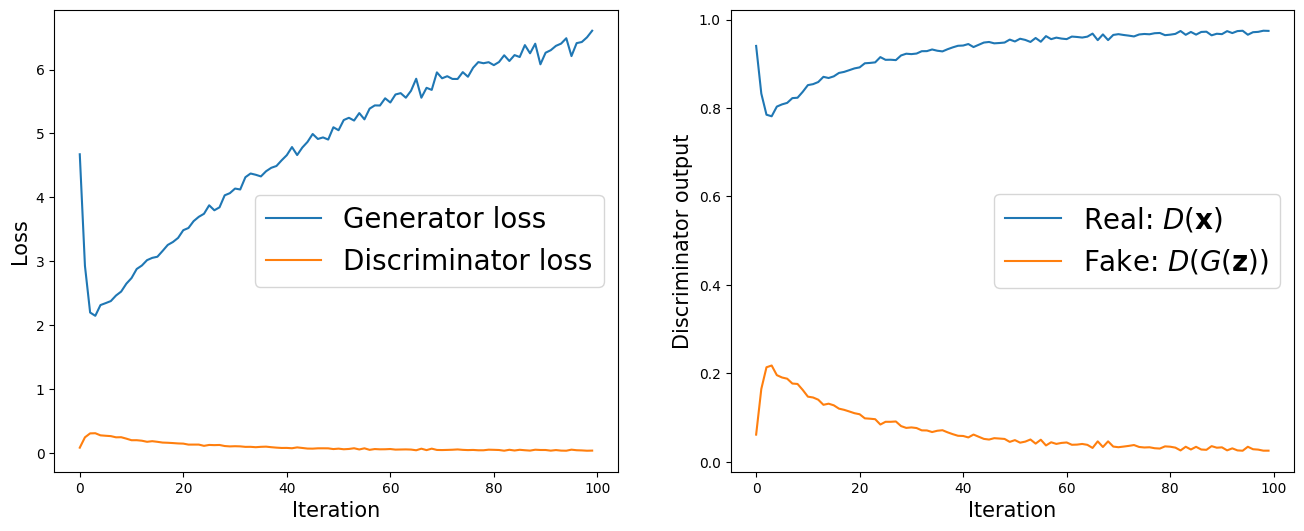

In [13]:
import itertools
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label="Generator loss")
half_d_losses = [all_d_loss / 2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label="Discriminator loss")
plt.legend(fontsize=20)
ax.set_xlabel("Iteration", size=15)
ax.set_ylabel("Loss", size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r"Real: $D(\mathbf{x})$")
plt.plot(all_d_fake, label=r"Fake: $D(G(\mathbf{z}))$")
plt.legend(fontsize=20)
ax.set_xlabel("Iteration", size=15)
ax.set_ylabel("Discriminator output", size=15)
plt.show()

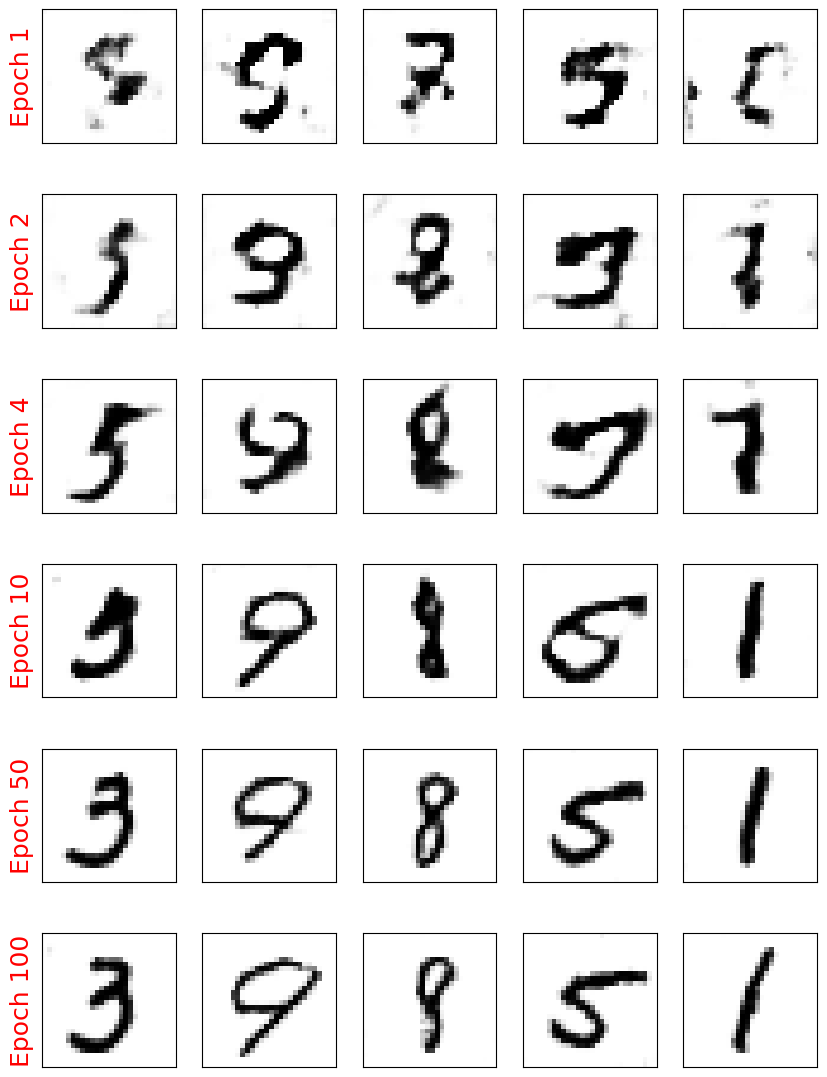

In [86]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i * 5 + j + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06,
                0.5,
                f"Epoch {e}",
                rotation=90,
                size=18,
                color="red",
                horizontalalignment="right",
                verticalalignment="center",
                transform=ax.transAxes,
            )

        image = epoch_samples[e - 1][j*5]
        ax.imshow(image, cmap="gray_r")

plt.show()

torch.Size([1, 100, 1, 1])


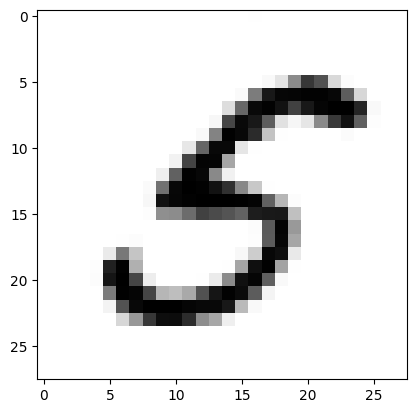

In [156]:
gen_model.cpu()
input_z = create_noise(1, z_size, mode_z)
print(input_z.shape)
output = create_samples(gen_model, input_z, batch_size=1).detach().cpu().numpy()
plt.imshow(output[0], cmap="gray_r")